In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import jax.numpy as jnp
import cloudpickle

from cellrank.kernels import VelocityKernel
from cellrank.estimators import GPCCA
from moscot.problems.time import TemporalProblem
import moscot.plotting as mtp
import seaborn as sns
from cellrank.kernels import RealTimeKernel

# Original Data loading

In [2]:
adata = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/adata_JAX_dataset_1.h5ad")
meta = pd.read_csv('/lustre/groups/ml01/workspace/monge_velo/data/df_cell.csv', index_col=0)
adata.obs['celltype'] = pd.Categorical(
    adata.obs['cell_id'].to_frame().merge(meta, on='cell_id', how='inner')['celltype_update']
)
adata.obs['major_trajectory'] = pd.Categorical(
    adata.obs['cell_id'].to_frame().merge(meta, on='cell_id', how='inner')['major_trajectory']
)
adata.obs['day'] = [float(x[1:]) for x in adata.obs['day']]
adata

AnnData object with n_obs × n_vars = 2840130 × 24552
    obs: 'cell_id', 'keep', 'day', 'embryo_id', 'experimental_batch', 'celltype', 'major_trajectory'
    var: 'gene_id', 'gene_type', 'gene_short_name', 'chr'

# Select timepoints

In [3]:
leave_in = [10.25, 10.50]
adata_time = adata[adata.obs['day'].isin(leave_in)].copy()
adata_time.obs['day'] = adata_time.obs['day'].astype('category')

#del adata

In [4]:
adata.obs['day'].unique()

array([ 8.5 ,  9.5 ,  9.25,  9.  ,  8.75,  9.75, 10.  , 10.5 , 10.25,
       10.75])

In [5]:
sc.pp.pca(adata_time)
sc.pp.neighbors(adata_time)
sc.tl.umap(adata_time)

### Plot Data

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


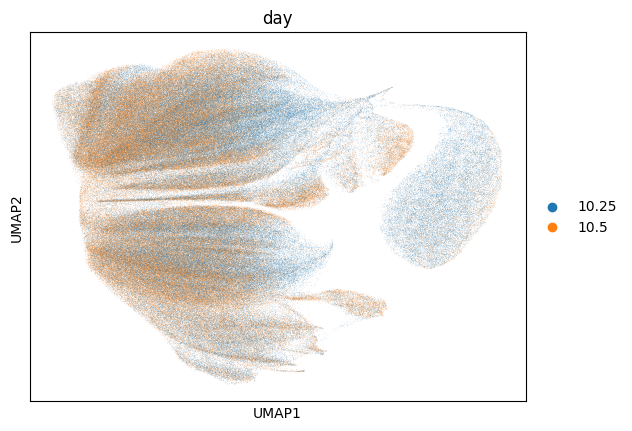

In [6]:
sc.pl.umap(adata_time, color='day')

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


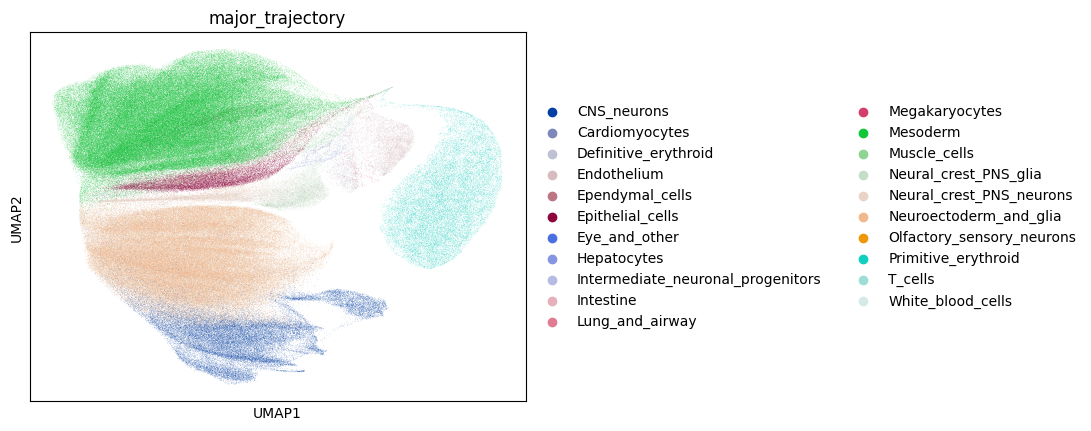

In [7]:
sc.pl.umap(adata_time, color='major_trajectory')

# Subsample

In [8]:
adata_sub = sc.pp.subsample(adata_time, n_obs=10000, copy=True)
sc.pp.pca(adata_sub)
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)

## Plot data

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


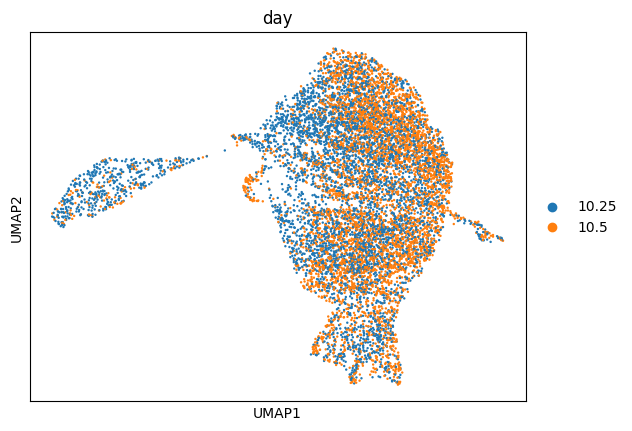

In [9]:
sc.pl.umap(adata_sub, color='day')

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


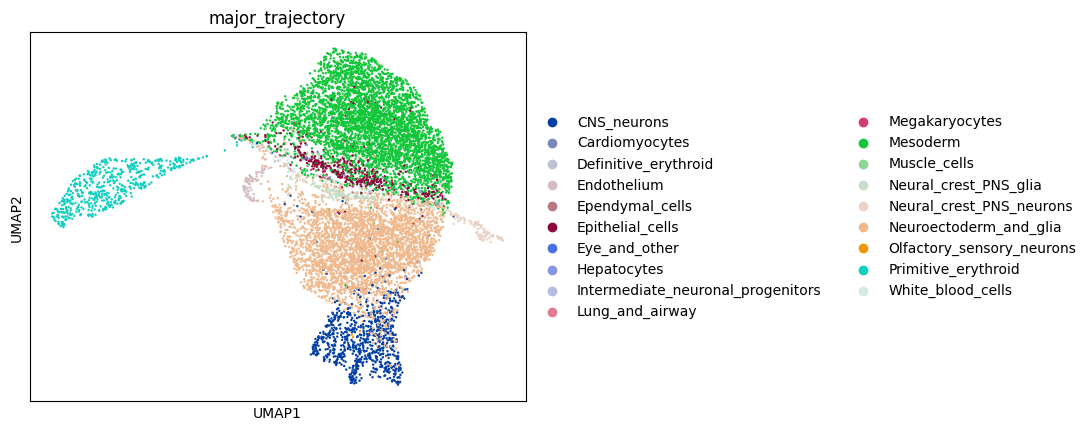

In [10]:
sc.pl.umap(adata_sub, color='major_trajectory')

# Compute temporal problem

In [11]:
tp = TemporalProblem(adata_sub)
tp = tp.prepare("day", joint_attr="X_pca")
tp = tp.solve(epsilon=1e-2)

INFO     Ordering Index(['run_19_PD-07E_S341.TCCTATAAGTAACCTGGTCT-3',                                              
                'run_19_PD-11H_S376.AAGCGCCATGTTCGTCAGA-3',                                                        
                'run_19_PD-08F_S350.TCGTCTATTTCCATAAGTCC-3',                                                       
                'run_19_PB-11A_S177.AGCATAACTTTTATCCGGAT-3',                                                       
                'run_19_PD-07G_S343.AGCGTAAGTTAGACTTCTT-3',                                                        
                'run_19_PD-10B_S362.TTCTCATTGTTAGGCCATAG-3',                                                       
                'run_19_PC-09B_S258.TGCCTTGGTGAGCATATGG-3',                                                        
                'run_19_PD-08D_S348.GTACCTCTTAATGCCGCTT-3',                                                        
                'run_19_PB-07H_S152.GATTACGGTTATATACTAA-3',             

2023-08-08 16:31:05.033332: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


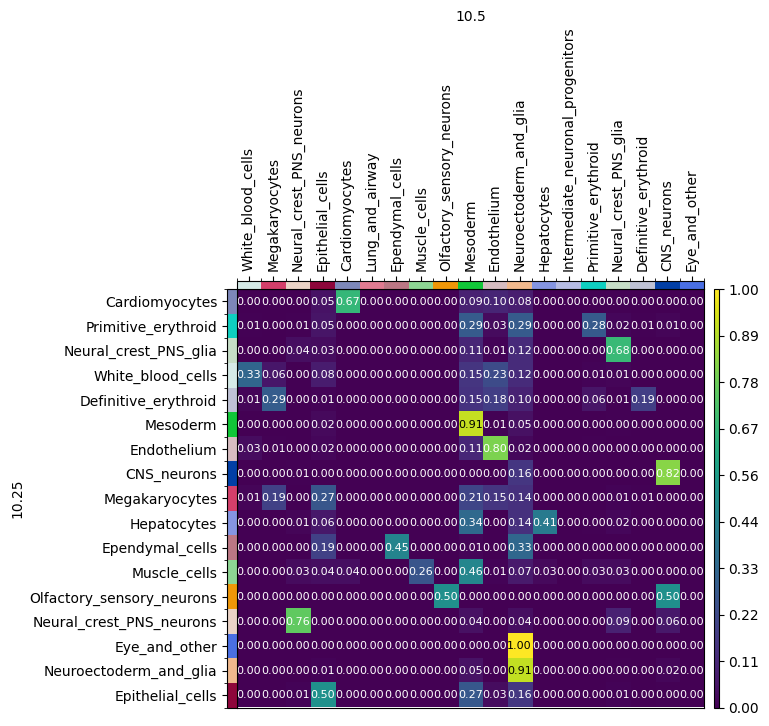

In [18]:
cell_transition = tp.cell_transition(
    source=10.25,
    target=10.50,
    source_groups='major_trajectory',
    target_groups='major_trajectory',
    forward=True,
    key_added="tp_transitions",
)

mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    key="tp_transitions",
)

# check subsample

In [17]:
adata_time.obs.celltype.value_counts()/len(adata_time.obs['celltype'])

celltype
Sclerotome                                 0.123531
Spinal cord/r7/r8                          0.112384
Facial mesenchyme                          0.094119
Lateral plate and intermediate mesoderm    0.077973
Limb mesenchyme progenitors                0.068788
                                             ...   
Glomerular endothelial cells               0.000004
Thyroid gland cells                        0.000004
Extraembryonic visceral endoderm           0.000002
T cells                                    0.000002
Midgut/Hindgut epithelial cells            0.000002
Name: count, Length: 117, dtype: float64

In [15]:
adata_sub.obs.celltype.value_counts()/10000

celltype
Sclerotome                                 0.1190
Spinal cord/r7/r8                          0.1163
Facial mesenchyme                          0.0948
Lateral plate and intermediate mesoderm    0.0838
Limb mesenchyme progenitors                0.0661
                                            ...  
Fibroblasts                                0.0001
Deep-layer neurons                         0.0001
Corticofugal neurons                       0.0001
Cerebellar Purkinje cells                  0.0001
Ureteric bud                               0.0001
Name: count, Length: 89, dtype: float64

# Velocities

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8738.13time pair/s]


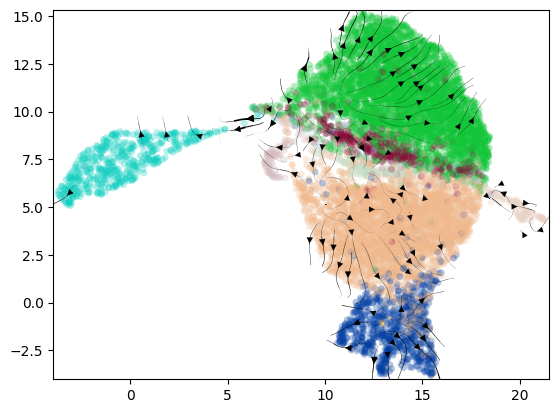

In [16]:
tmk = RealTimeKernel.from_moscot(tp)
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")
try:
    tmk.plot_projection(connectivities=adata_sub.obsp['connectivities'], color='major_trajectory')
except:
    pass